In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow as tf

2024-06-16 13:30:16.159781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 13:30:16.782223: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-16 13:30:19.790726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/felipe/miniconda3/envs/tf/lib/
2024-06-16 13:30:19.791168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

In [4]:
# load in the data
df = pd.read_csv('./data_clean/ratings.csv')
df.head(5)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1246,5.0,1425941556
4,1,1968,4.0,1425942148


In [6]:
N = df.userId.max() + 1 # number of users
M = df.movieId.max() + 1 # number of movies

In [7]:
# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [8]:
# initialize variables
K = 5 # latent dimensionality
mu = df_train.rating.mean()
epochs = 15
reg = 0. # regularization penalty


# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u) # (N, 1, K)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m) # (N, 1, K)


u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u) # (N, 1, 1)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)


x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)

model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 5)         1354485     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 5)         881370      ['input_2[0][0]']                
                                                                                              

2024-06-16 13:32:40.261660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-16 13:32:40.311619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-16 13:32:40.311991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-16 13:32:40.313044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [11]:
r = model.fit(
  x=[df_train.userId.values, df_train.movieId.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.movieId.values],
    df_test.rating.values - mu
  )
)

Epoch 1/15
71499/71499 [==============================] - 355s 5ms/step - loss: 0.8442 - mse: 0.8442 - val_loss: 0.8063 - val_mse: 0.8063
Epoch 2/15
71499/71499 [==============================] - 298s 4ms/step - loss: 0.7760 - mse: 0.7760 - val_loss: 0.7587 - val_mse: 0.7587
Epoch 3/15
71499/71499 [==============================] - 291s 4ms/step - loss: 0.7155 - mse: 0.7155 - val_loss: 0.7222 - val_mse: 0.7222
Epoch 4/15
71499/71499 [==============================] - 288s 4ms/step - loss: 0.6661 - mse: 0.6661 - val_loss: 0.7054 - val_mse: 0.7054
Epoch 5/15
71499/71499 [==============================] - 289s 4ms/step - loss: 0.6352 - mse: 0.6352 - val_loss: 0.6992 - val_mse: 0.6992
Epoch 6/15
71499/71499 [==============================] - 288s 4ms/step - loss: 0.6163 - mse: 0.6163 - val_loss: 0.6973 - val_mse: 0.6973
Epoch 7/15
71499/71499 [==============================] - 287s 4ms/step - loss: 0.6035 - mse: 0.6035 - val_loss: 0.6963 - val_mse: 0.6963
Epoch 8/15
71499/71499 [==========

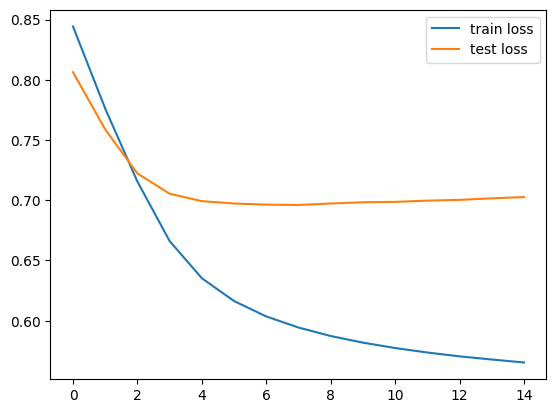

In [12]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

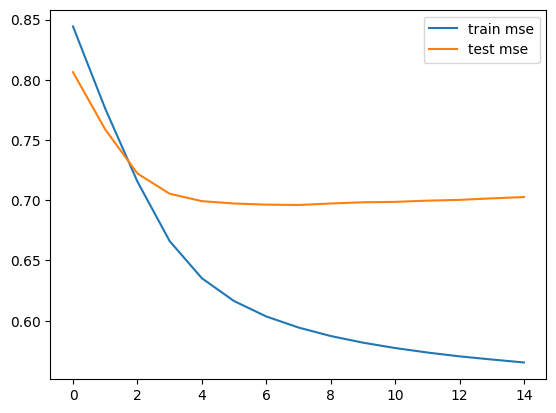

In [13]:
# plot mse
plt.plot(r.history['mse'], label="train mse")
plt.plot(r.history['val_mse'], label="test mse")
plt.legend()
plt.show()

In [23]:
model.save('model_CF.h5')

In [5]:
model =  tf.keras.models.load_model('model_CF.h5')

2024-06-15 23:46:13.331634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-15 23:46:13.339724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-15 23:46:13.340032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-15 23:46:13.340604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [18]:
# Datos para recomendar
user_id = 1
movie_ids = np.array(df["movieId"].values[:400])  # IDs de películas disponibles

# Crear las entradas para el modelo
user_ids = np.full(len(movie_ids), user_id)

# Hacer predicciones
predicted_ratings = model.predict([user_ids, movie_ids])

# Seleccionar las mejores recomendaciones
top_indices = np.argsort(predicted_ratings[:, 0])[::-1]
top_movie_ids = movie_ids[top_indices]

print(
    "Películas recomendadas para el usuario {}: {}".format(user_id, top_movie_ids[:50])
)

13/13 [==============================] - 0s 1ms/step
Películas recomendadas para el usuario 1: [  527   527   527   318   318   318   318   318   318   318 44555  4973
  4973  8014   265  1246  1961   858  1271   290   110   110   110 96821
   590   590  6016  1934  4226  4226  4226   593   593   593  1250  1873
  2064   954  1537 40819  1259  1259 89492  2762  2762  2762  2762 48780
 48780 48780]
